In [32]:
import numpy as np
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
from visualizations import plot_geopandas, plot_correlation, plot_pie, plot_dist
from matplotlib import pyplot as plt
from pns_dict import PNS_DICT
from visualizations import plot_bar
import seaborn as sns

from constants import BRAZIL_IDH

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))

PATH_GEN_DATA = Path('generated_data/pns_data_description').resolve()

def save_fig(fig_i, name):
    fig_i.savefig(PATH_GEN_DATA / '00_pns_{}.png'.format(name), bbox_inches='tight')
    fig_i.savefig(PATH_GEN_DATA / '00_pns_{}.pdf'.format(name), bbox_inches='tight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
print("O dataset PNS possui {} linhas e {} colunas (features).".format(*df.shape))

O dataset PNS possui 90846 linhas e 381 colunas (features).


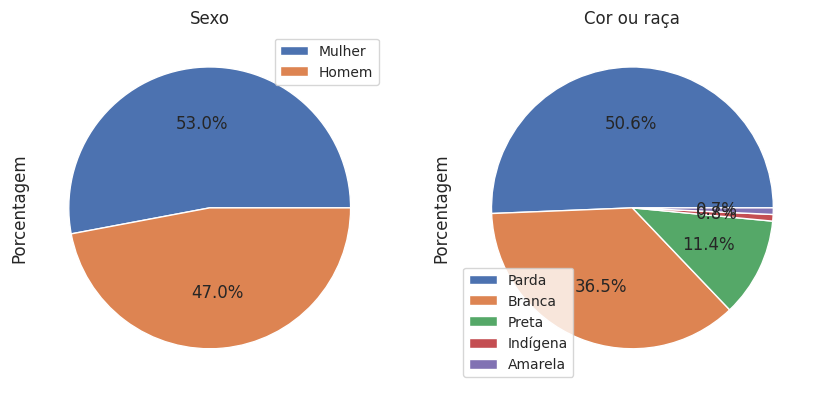

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_pie(df, 'sexo', 'Sexo', desc_dict=PNS_DICT.get_pv_dict('sexo'), ax=axes[0])
plot_pie(df, 'cor', 'Cor ou raça', desc_dict=PNS_DICT.get_pv_dict('cor'), ax=axes[1])
save_fig(fig, 'sexo_cor')
plt.show()

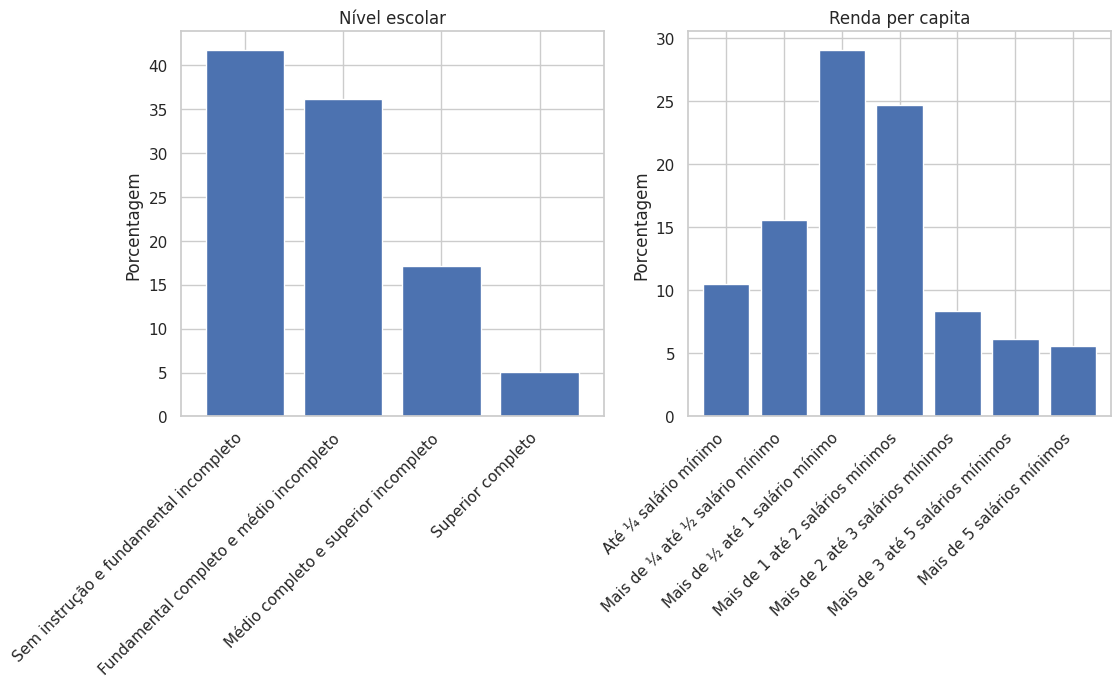

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_bar(df, 'escolaridade_agregada', 'Nível escolar', desc_dict=PNS_DICT.get_pv_dict('escolaridade_agregada'), ax=axes[0])
plot_bar(df, 'renda_pc', 'Renda per capita', desc_dict=PNS_DICT.get_pv_dict('renda_pc'), ax=axes[1])
save_fig(fig, 'escolaridade_renda')
plt.show()

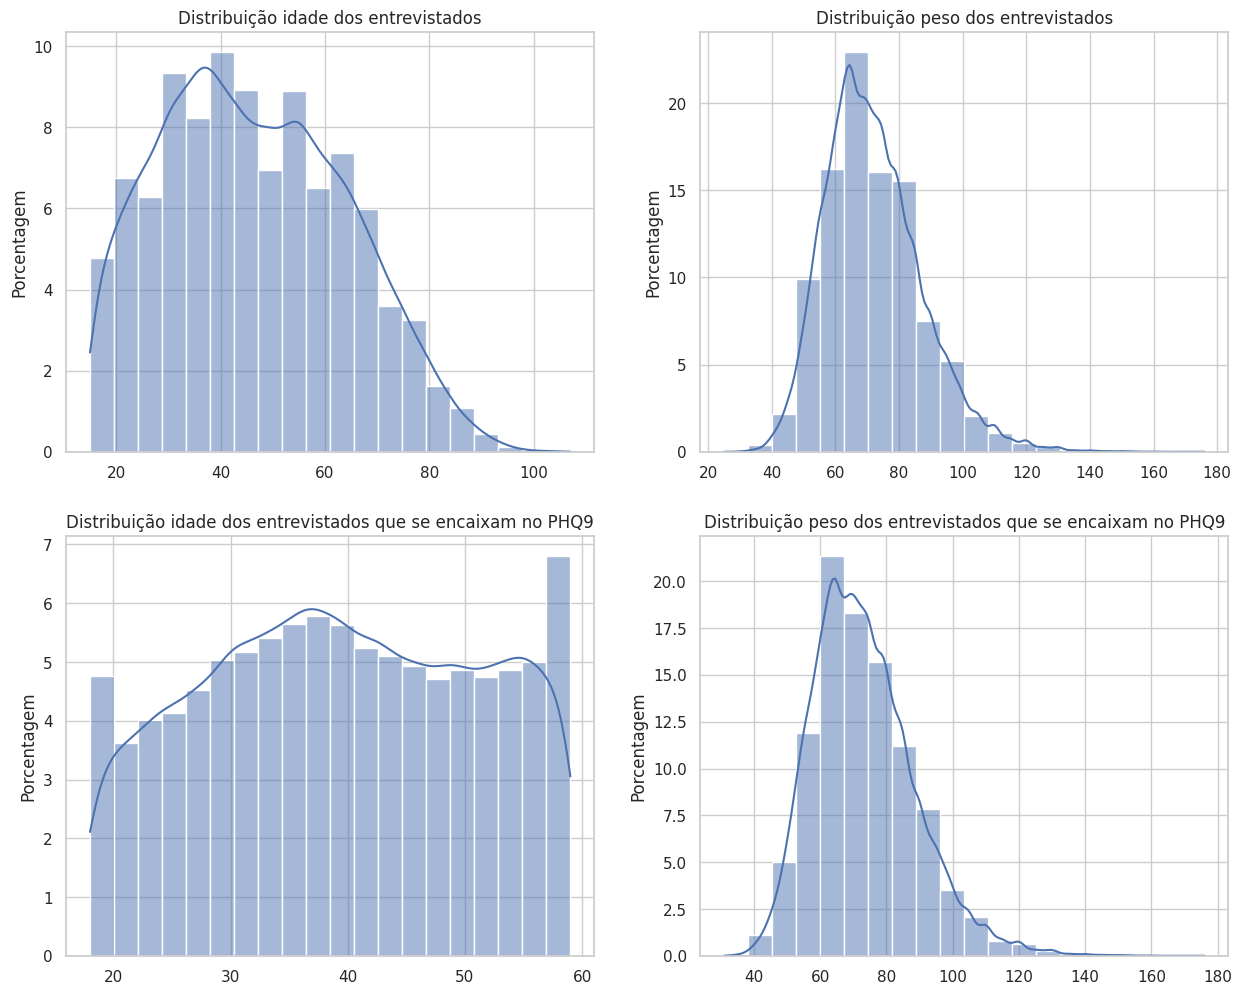

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_dist(df['idade'], 'Distribuição idade dos entrevistados', ax=axes[0, 0])
plot_dist(df['peso'], 'Distribuição peso dos entrevistados', ax=axes[0, 1])

selected = df.dropna(subset=['phq9_total'])
plot_dist(selected['idade'], 'Distribuição idade dos entrevistados que se encaixam no PHQ9', ax=axes[1, 0])
plot_dist(selected['peso'], 'Distribuição peso dos entrevistados que se encaixam no PHQ9', ax=axes[1, 1])
save_fig(fig, 'idade_peso')
plt.show()

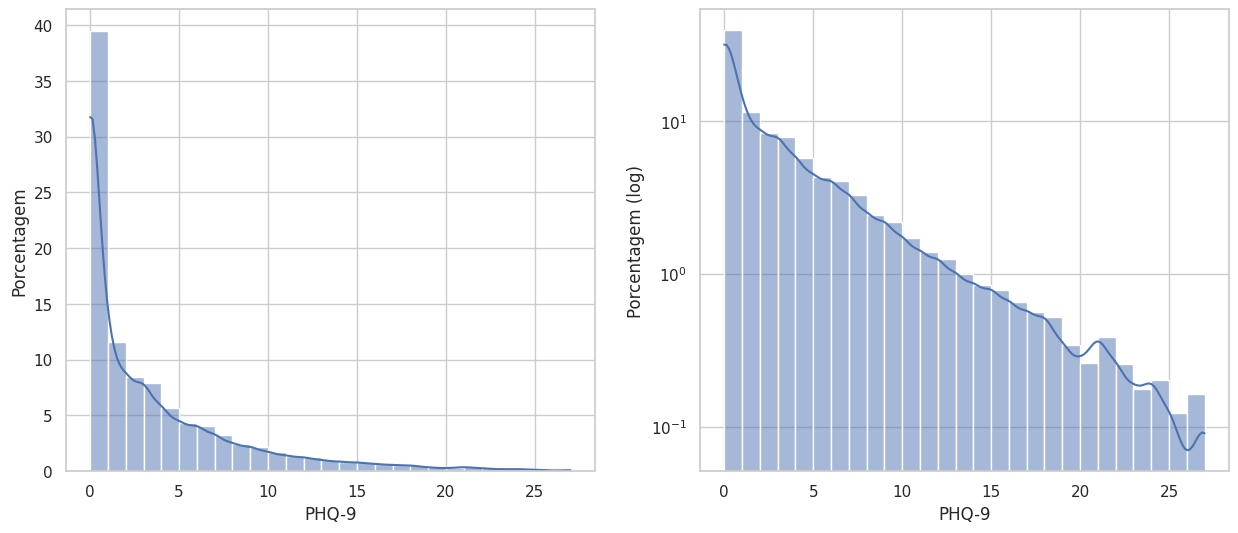

In [37]:
selected = df.dropna(subset=['phq9_total'])
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(selected['phq9_total'], bins=27, kde=True, ax=ax[0], stat='percent')
ax[0].set_ylabel('Porcentagem')
ax[0].set_xlabel('PHQ-9')

sns.histplot(selected['phq9_total'], bins=27, kde=True, ax=ax[1], stat='percent')
ax[1].set_yscale('log')
ax[1].set_ylabel('Porcentagem (log)')
ax[1].set_xlabel('PHQ-9')


save_fig(fig, 'phq9_total_dist')
plt.show()

# Estado de depressão e suas relações

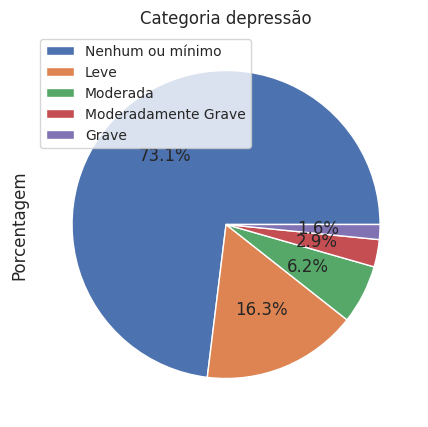

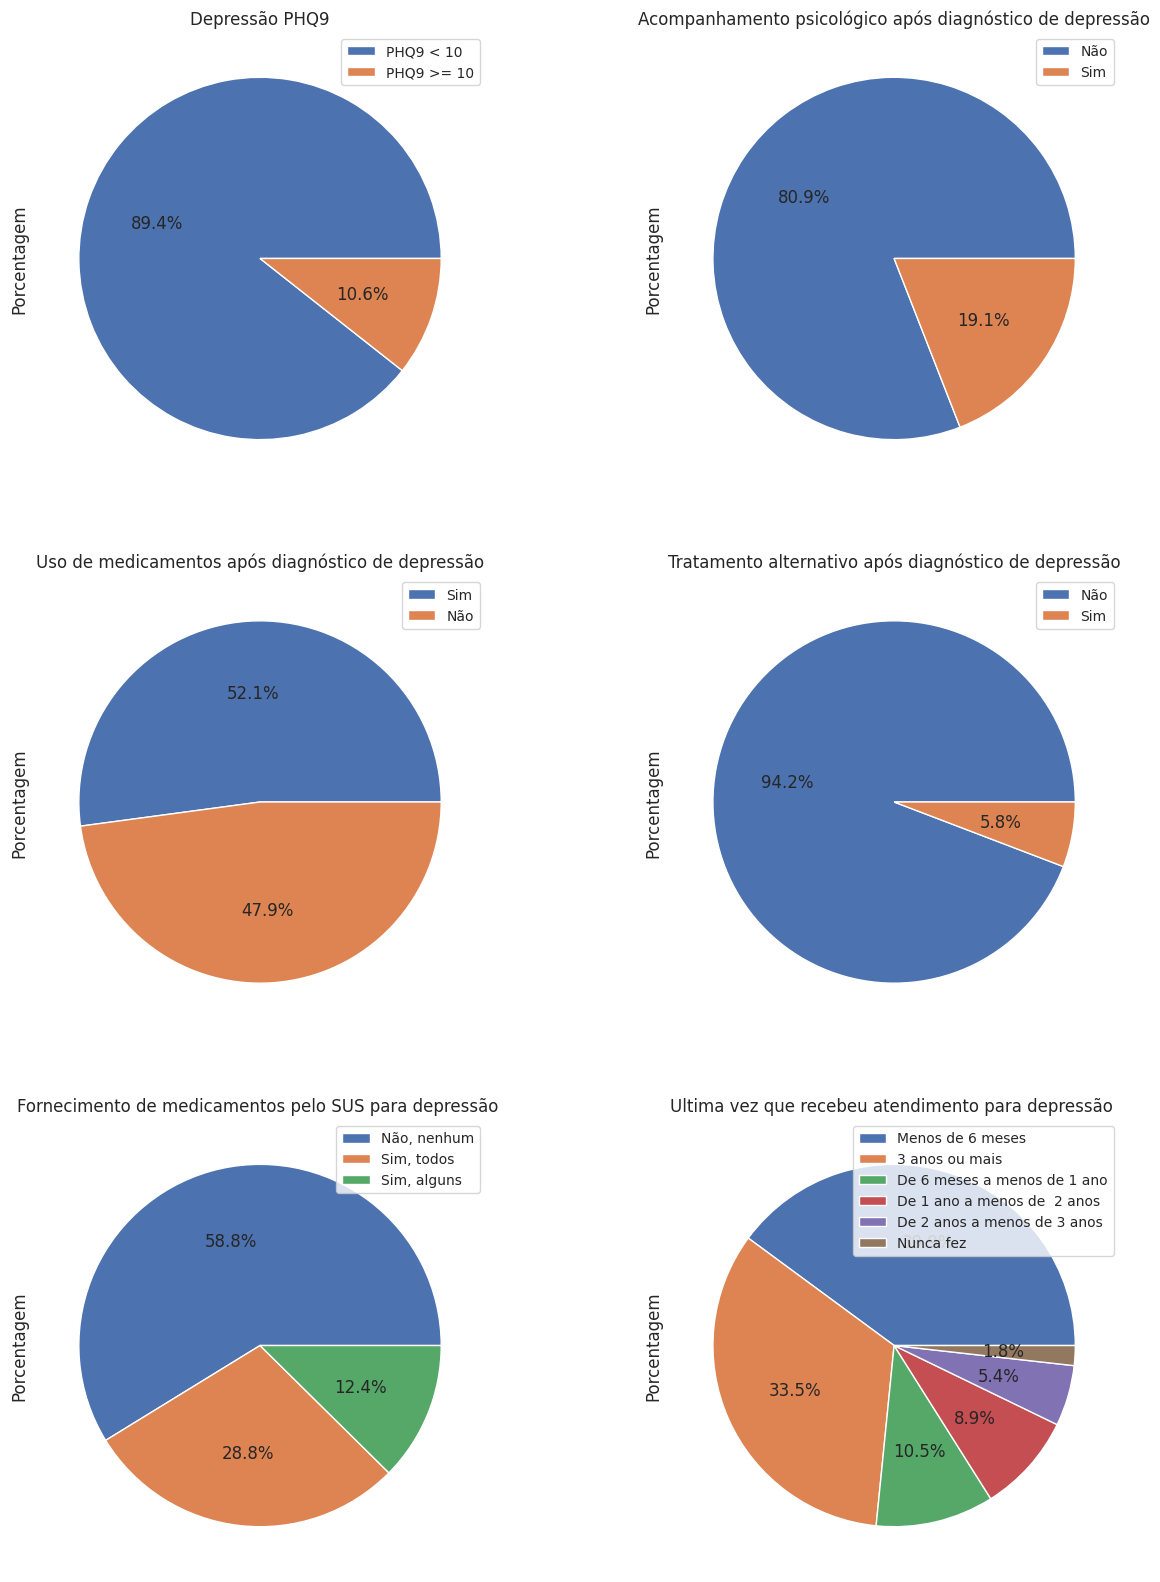

In [43]:
fig, axes = plt.subplots(figsize=(5, 5))
plot_pie(df, 'depression_severity',  'Categoria depressão', desc_dict=PNS_DICT.get_pv_dict('depression_severity'), ax=axes)
save_fig(fig, 'depression_phq9_sev')
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
plot_pie(df, 'depression', 'Depressão PHQ9', desc_dict={0: "PHQ9 < 10", 1: "PHQ9 >= 10"}, ax=axes[0][0])
plot_pie(df, 'Q09605', 'Acompanhamento psicológico após diagnóstico de depressão', desc_dict=PNS_DICT.get_pv_dict('Q09605'), ax=axes[0][1])
plot_pie(df, 'Q09606', 'Uso de medicamentos após diagnóstico de depressão', desc_dict=PNS_DICT.get_pv_dict('Q09606'), ax=axes[1][0])
plot_pie(df, 'Q09607', 'Tratamento alternativo após diagnóstico de depressão', desc_dict=PNS_DICT.get_pv_dict('Q09607'), ax=axes[1][1])
plot_pie(df, 'Q098', 'Fornecimento de medicamentos pelo SUS para depressão ', desc_dict=PNS_DICT.get_pv_dict('Q098'), ax=axes[2][0])
plot_pie(df, 'Q10101', 'Ultima vez que recebeu atendimento para depressão ', desc_dict=PNS_DICT.get_pv_dict('Q10101'), ax=axes[2][1])
save_fig(fig, 'depression_stats')
plt.show()

# Distribuição depressão estados Brasil

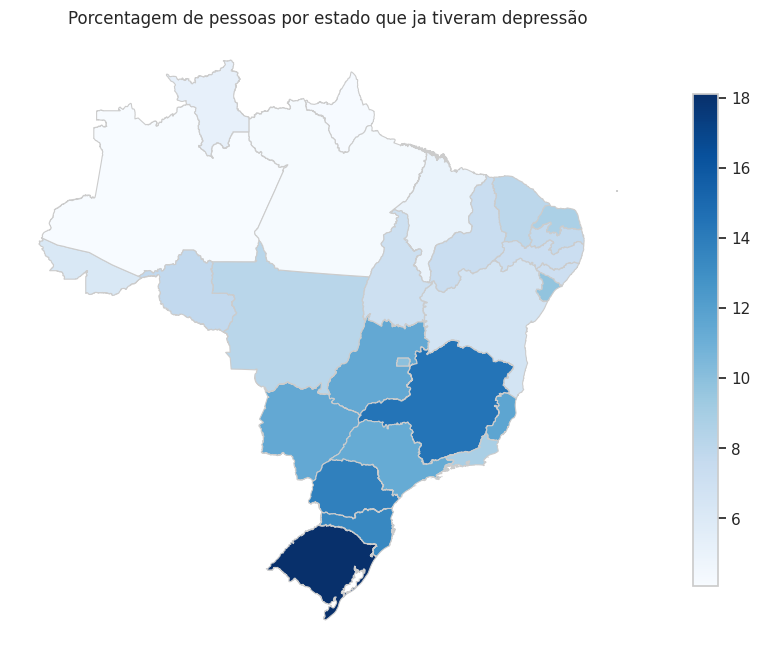

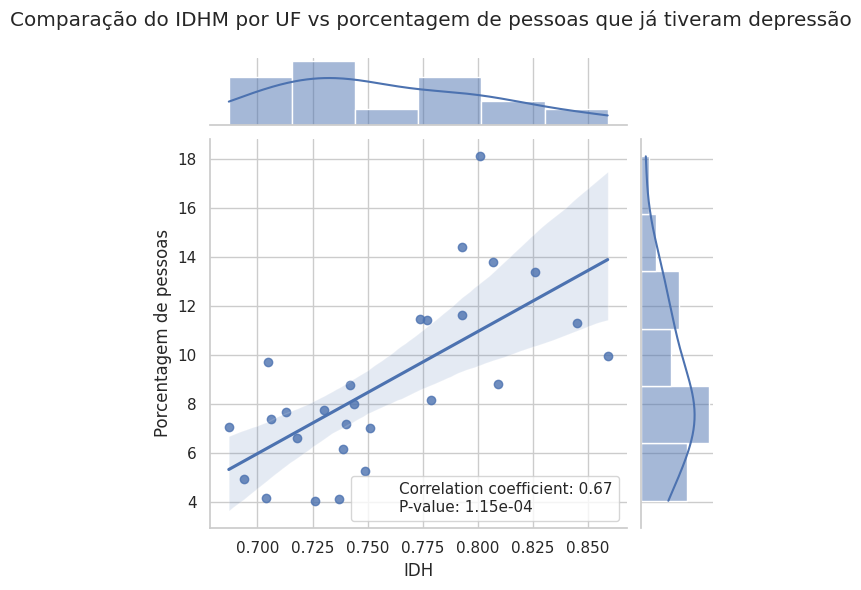

In [39]:
selected = df[['uf']][df['Q092'].isin([1])].value_counts() * 100 / df[['uf']].value_counts()
selected.name = 'values'
selected = selected.reset_index()
fig = plot_geopandas(selected, title="Porcentagem de pessoas por estado que ja tiveram depressão", uf_key='uf')
save_fig(fig, 'brazil_depression')

selected2 = BRAZIL_IDH.merge(selected, left_on='codigo_ibg', right_on='uf')

fig = plot_correlation(selected2, x='IDHM', y='values',
                       title='Comparação do IDHM por UF vs porcentagem de pessoas que já tiveram depressão',
                       xlabel='IDH', ylabel='Porcentagem de pessoas')

save_fig(fig, 'depression_idh_correlation')

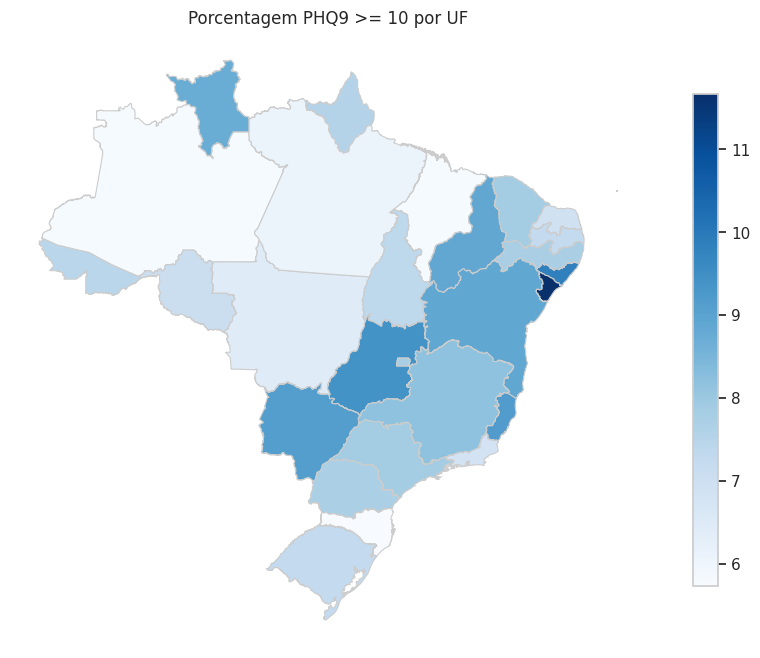

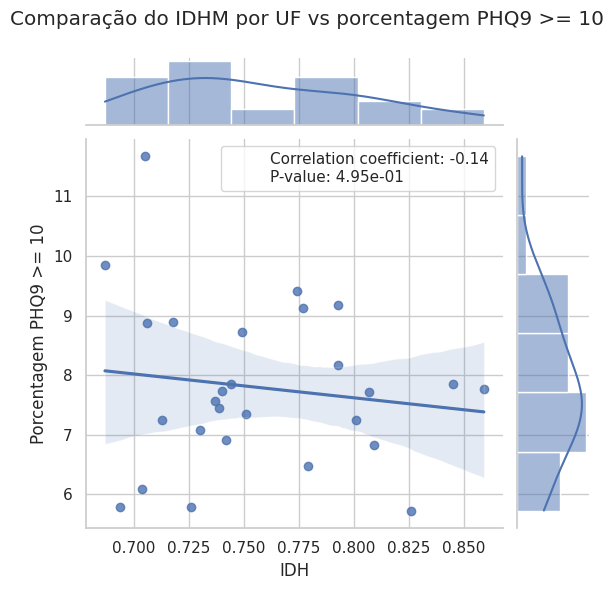

In [40]:
selected = df[['uf']][df['depression'].isin([1])].value_counts() * 100 / df[['uf']].value_counts()

selected.name = 'values'
selected = selected.reset_index()
fig = plot_geopandas(selected, title="Porcentagem PHQ9 >= 10 por UF", uf_key='uf')
save_fig(fig, 'brazil_phq9')
plt.show()

selected2 = BRAZIL_IDH.merge(selected, left_on='codigo_ibg', right_on='uf')

fig = plot_correlation(selected2, x='IDHM', y='values',
                       title='Comparação do IDHM por UF vs porcentagem PHQ9 >= 10',
                       xlabel='IDH', ylabel='Porcentagem PHQ9 >= 10')

save_fig(fig, 'phq9_idh_correlation')